In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d nibinv23/iam-handwriting-word-database

100% 1.10G/1.10G [00:59<00:00, 21.3MB/s]
100% 1.10G/1.10G [00:59<00:00, 20.0MB/s]


In [5]:
from zipfile import ZipFile
file_name = "/content/iam-handwriting-word-database.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [6]:
!head -20 /content/iam_words/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [7]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [8]:
basepath="iam_words"
wordslist=[]
words = open("/content/iam_words/words.txt","r").readlines()
for line in words:
  #print(line)
  if line[0]=="#":
    continue
  elements = line.split()
  if len(elements) > 1 and elements[1] != "err":
    wordslist.append(line)
print(len(wordslist))
np.random.shuffle(wordslist)

38305


In [9]:
print(wordslist[0:10])

['d06-100-04-08 ok 179 1538 1475 95 57 AT a\n', 'a01-026x-07-04 ok 186 1260 2230 31 46 , ,\n', 'a04-081-09-04 ok 172 1413 2528 293 127 NN industry\n', 'b04-195-03-02 ok 182 783 1173 181 169 NN degree\n', 'd07-100-09-00 ok 170 345 2334 173 130 NN part\n', 'e01-092-02-00 ok 179 346 1104 109 50 BER are\n', 'a01-026u-05-06 ok 169 2117 1690 248 80 NNS parties\n', 'b02-102-02-06 ok 192 1617 1085 81 82 INO of\n', 'b01-073-03-04 ok 172 1056 1276 114 51 CD 400\n', 'a01-122u-03-03 ok 173 1425 1358 10 10 . .\n']


In [10]:
split_idx = int(0.9 * len(wordslist))
train_samples = wordslist[:split_idx]
test_samples = wordslist[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]


assert len(wordslist) == len(train_samples) + len(validation_samples) + len(test_samples)

print("tot train samples ", len(train_samples))
print("tot validation samples ", len(validation_samples))
print("tot test samples ", len(test_samples))

tot train samples  34474
tot validation samples  1915
tot test samples  1916


In [11]:
base_image_path = os.path.join(basepath,"words")

def get_image_paths_and_labels(samples):
  paths=[]
  corrected_samples=[]
  for (i, file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")


    image_name=line_split[0]
    part1 = image_name.split("-")[0]
    part2 = image_name.split("-")[1]
    img_path = os.path.join(base_image_path, part1, part1 + "-" + part2, image_name + ".png" )

    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])

  return paths, corrected_samples


train_img_paths, train_labels= get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [12]:
train_img_paths[0:10]

['iam_words/words/d06/d06-100/d06-100-04-08.png',
 'iam_words/words/a01/a01-026x/a01-026x-07-04.png',
 'iam_words/words/a04/a04-081/a04-081-09-04.png',
 'iam_words/words/b04/b04-195/b04-195-03-02.png',
 'iam_words/words/d07/d07-100/d07-100-09-00.png',
 'iam_words/words/e01/e01-092/e01-092-02-00.png',
 'iam_words/words/a01/a01-026u/a01-026u-05-06.png',
 'iam_words/words/b02/b02-102/b02-102-02-06.png',
 'iam_words/words/b01/b01-073/b01-073-03-04.png',
 'iam_words/words/a01/a01-122u/a01-122u-03-03.png']

In [13]:
train_labels[0:10]

['d06-100-04-08 ok 179 1538 1475 95 57 AT a',
 'a01-026x-07-04 ok 186 1260 2230 31 46 , ,',
 'a04-081-09-04 ok 172 1413 2528 293 127 NN industry',
 'b04-195-03-02 ok 182 783 1173 181 169 NN degree',
 'd07-100-09-00 ok 170 345 2334 173 130 NN part',
 'e01-092-02-00 ok 179 346 1104 109 50 BER are',
 'a01-026u-05-06 ok 169 2117 1690 248 80 NNS parties',
 'b02-102-02-06 ok 192 1617 1085 81 82 INO of',
 'b01-073-03-04 ok 172 1056 1276 114 51 CD 400',
 'a01-122u-03-03 ok 173 1425 1358 10 10 . .']

In [14]:
train_labels_cleaned=[]
characters= set()
max_len=0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)
  max_len= max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Max length: ", max_len)
print("Vocab size: ",len(characters))

Max length:  19
Vocab size:  76


In [15]:
train_labels_cleaned[:10]

['a', ',', 'industry', 'degree', 'part', 'are', 'parties', 'of', '400', '.']

In [16]:
def clean_labels(labels):
  cleaned_labels=[]
  for label in  labels:
    label=label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

validation_labels_cleaned=clean_labels(validation_labels)
test_labels_cleaned= clean_labels(test_labels)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary=list(characters),mask_token=None)

num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(),mask_token=None,invert=True)

In [18]:
def distortion_free_resize(image, img_size):
  w,h= img_size
  image = tf.image.resize(image, size=(h,w),preserve_aspect_ratio=True)

  pad_height= h - tf.shape(image)[0]
  pad_width= w - tf.shape(image)[1]

  if pad_height % 2!=0:
    height = pad_height //2
    pad_height_top= height+1
    pad_height_bottom=height

  else:
    pad_height_top= pad_height_bottom = pad_height // 2

  if pad_width % 2 !=0:
    width = pad_width //2
    pad_width_left = width+1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width //2


  image = tf.pad(
      image,
      paddings=[
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],[0,0]
      ],
  )

  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  return image

In [19]:
batch_size=64
padding_token = 99
image_width = 128
image_height =32


def preprocess_image(image_path, img_size=(image_width, image_height)):
  image= tf.io.read_file(image_path)
  image= tf.image.decode_png(image,1)
  image= distortion_free_resize(image, img_size)
  image= tf.cast(image, tf.float32)/ 255.0
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label,input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings=[[0,pad_amount]],constant_values=padding_token)
  return label

def process_image_labels(image_path,label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return {"image":image, "label":label}

def prepare_dataset(image_paths,labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths,labels)).map(
      process_image_labels, num_parallel_calls=AUTOTUNE
  )
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [20]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

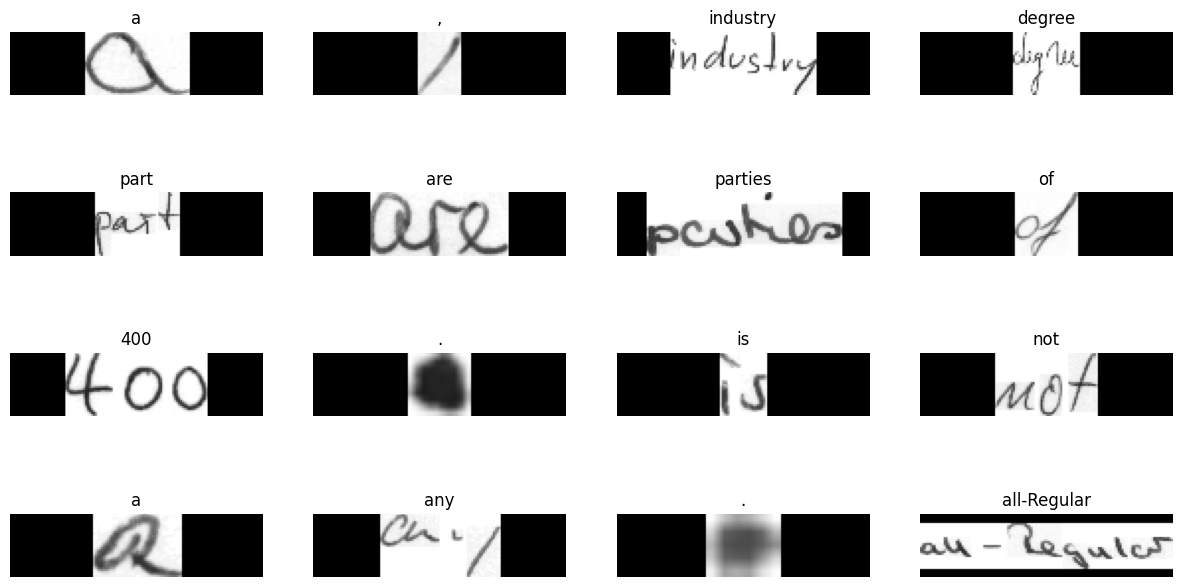

In [21]:
for data in train_ds.take(1):
  images, labels = data["image"], data["label"]

  _,ax = plt.subplots(4,4,figsize=(15,8))

  for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1,0,2])
    img = (img * 255.0).numpy().clip(0,255).astype(np.uint8)
    img = img[:,:,0]

    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label,padding_token)))

    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

  plt.show()

In [22]:
class CTCLayer(keras.layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn= keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len= tf.cast(tf.shape(y_true)[0],dtype="int64")
    input_length= tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length= tf.cast(tf.shape(y_true)[1],dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len ,1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len ,1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    return y_pred




def build_model():
  input_img = keras.Input(shape=(image_width, image_height,1),name="image")
  labels = keras.layers.Input(name="label",shape=(None,))

  x = keras.layers.Conv2D(
      32,
      (3,3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv1",
  )(input_img)
  x = keras.layers.MaxPooling2D((2,2), name="pool")(x)

  x = keras.layers.Conv2D(
      64,
      (3,3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
        name="Conv2",
    )(x)
  x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
  x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)


  x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

  output = CTCLayer(name="ctc_loss")(labels, x)
  model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
  opt = keras.optimizers.Adam()
  model.compile(optimizer=opt)
  return model

model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool (MaxPooling2D)            (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool[0][0]

In [23]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])




def calculate_edit_distance(labels, predictions):
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [24]:
epochs = 10

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/10
2/2 [==============================] - 2s 122ms/step
Mean edit distance for epoch 1: 18.8299
539/539 [==============================] - 89s 128ms/step - loss: 15.4033 - val_loss: 13.6196
Epoch 2/10
2/2 [==============================] - 0s 16ms/step
Mean edit distance for epoch 2: 18.5508
539/539 [==============================] - 37s 69ms/step - loss: 13.0154 - val_loss: 12.4757
Epoch 3/10
2/2 [==============================] - 0s 10ms/step
Mean edit distance for epoch 3: 18.2777
539/539 [==============================] - 31s 57ms/step - loss: 11.7851 - val_loss: 10.9493
Epoch 4/10
2/2 [==============================] - 0s 11ms/step
Mean edit distance for epoch 4: 18.1156
539/539 [==============================] - 31s 58ms/step - loss: 10.6653 - val_loss: 10.0495
Epoch 5/10
2/2 [==============================] - 0s 12ms/step
Mean edit distance for epoch 5: 17.8607
539/539 [==============================] - 34s 64ms/step - loss: 9.7791 - val_loss: 9.1202
Epoch 6/10
2/2 [====

2/2 [==============================] - 0s 9ms/step


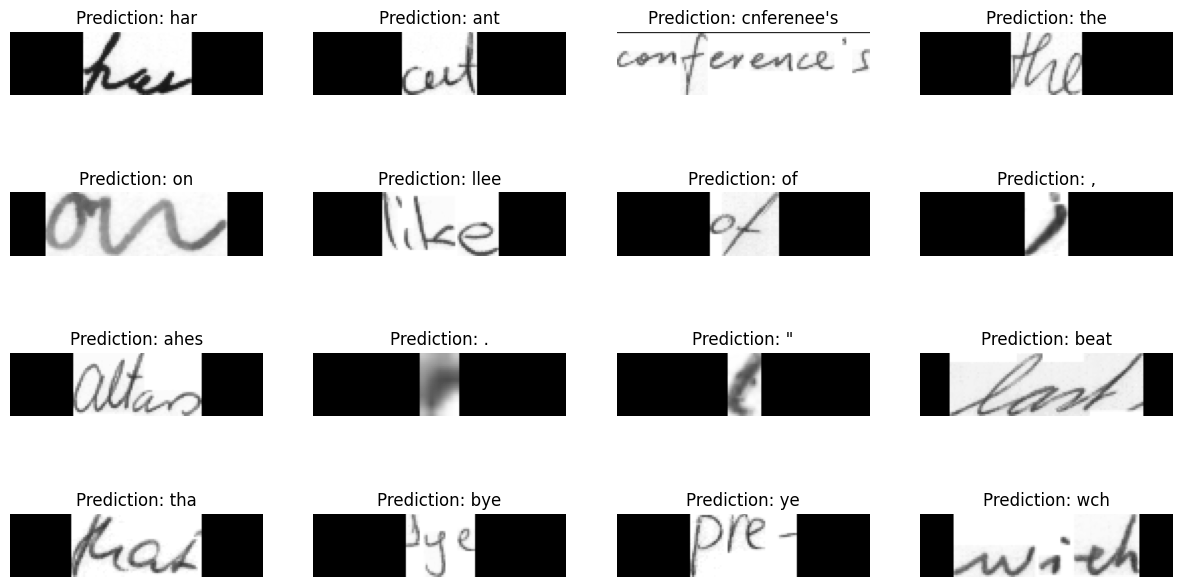

In [25]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [36]:
def tensor_to_text(tensor_label):
    label_chars = []
    for char_idx in tensor_label:
        if char_idx == padding_token:
            break
        label_chars.append(num_to_char(char_idx))
    return tf.strings.join(label_chars).numpy().decode("utf-8")

def calculate_accuracy(model, dataset):
    total_count = 0
    correct_count = 0

    for batch in dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(len(pred_texts)):
            total_count += 1
            #print(pred_texts[i], "  i   ", tensor_to_text(batch_labels[i]))
            if pred_texts[i] == tensor_to_text(batch_labels[i]):
                correct_count += 1

    accuracy = correct_count / total_count
    return accuracy

accuracy = calculate_accuracy(prediction_model, test_ds)
print("Accuracy: {:.2%}".format(accuracy))

2/2 [==============================] - 0s 11ms/step
Accuracy: 82.67%


In [42]:
def calculate_performance_metrics(model, dataset, beta=2):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_count = 0
    correct_count = 0

    for batch in dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(len(pred_texts)):
            total_count += 1
            if pred_texts[i] == tensor_to_text(batch_labels[i]):
                correct_count += 1
                true_positives += 1
            else:
                false_positives += 1
                false_negatives += 1

    accuracy = correct_count / total_count
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f2_score = (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))

    performance_metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
        "F2 Score": f2_score
    }
    return performance_metrics

print(calculate_performance_metrics(prediction_model, test_ds))

2/2 [==============================] - 0s 11ms/step
{'Accuracy': 0.826722338204593, 'Precision': 0.826722338204593, 'Recall': 0.826722338204593, 'F2 Score': 0.826722338204593}


1/1 [==============================] - 0s 21ms/step


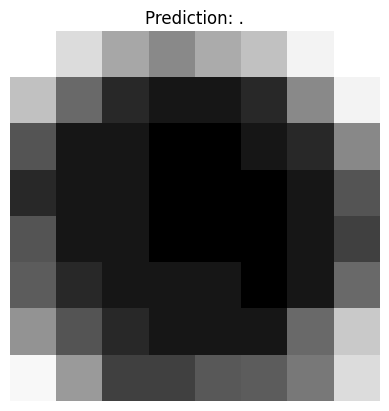

In [32]:
def test_custom_image(image_path, model):
    image = preprocess_image(image_path)
    image = tf.expand_dims(image, axis=0)

    pred = model.predict(image)
    pred_text = decode_batch_predictions(pred)[0]

    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, 1)
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = tf.cast(img, tf.uint8)
    img = tf.clip_by_value(img, 0, 255)
    img = img.numpy()[:, :, 0]

    plt.imshow(img, cmap="gray")
    plt.title(f"Prediction: {pred_text}")
    plt.axis("off")
    plt.show()

custom_image_path = "/content/iam_words/words/a04/a04-000/a04-000-03-05.png"
test_custom_image(custom_image_path, prediction_model)


In [35]:
export_path = "/content/model"
tf.saved_model.save(prediction_model, export_path)

In [43]:
from google.colab import files
!zip -r model.zip {export_path}
files.download("model.zip")

  adding: content/model/ (stored 0%)
  adding: content/model/fingerprint.pb (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 91%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 60%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>